### Inicializar módulos

In [1]:
#Initialize
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

#Paths & names
image_path = "C:\\Users\\JH\\Dropbox\\ForcastChallenge\\sampleImgs\\"

#Region of interest
roiX = 140
roiY = 280
roiW = 1120
roiH = 600

def getROI(img):
    return img[(-roiY-roiH):(-roiY),roiX:(roiX+roiW)]

def myimread(path):
    img_bgr = cv2.imread(path)
    roi_bgr = getROI(img_bgr)
    return cv2.cvtColor(roi_bgr,cv2.COLOR_BGR2RGB)

#'Background' image
bgm_img_name = "snap_2018-04-17_12_07_01.jpeg"
bg_img = myimread(image_path + bgm_img_name)

#Test image
test_img_name = "snap_2018-04-17_13_23_53.jpeg"

#Get image list
a = list(os.walk(image_path))
_,_,file_names = a[0]



### Visualizar histograma de diferencia de tiempo entre imagenes

(array([282., 151.,  48.,  63., 129.,  63.,  76., 135., 100.,  91., 204.,
         87., 136.,  40.,  31.,  46.,  45.,  26.,  38.,  35.,  36.,  40.,
         29.,  18.,  19.,  21.,  10.,  10.,   4.,   8.,   6.,   6.,   6.,
          6.,   0.,   1.,   1.,   2.,   0.,   0.,   2.,   1.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([ 1.  ,  2.08,  3.16,  4.24,  5.32,  6.4 ,  7.48,  8.56,  9.64,
        10.72, 11.8 , 12.88, 13.96, 15.04, 16.12, 17.2 , 18.28, 19.36,
        20.44, 21.52, 22.6 , 23.68, 24.76, 25.84, 26.92, 28.  , 29.08,
        30.16, 31.24, 32.32, 33.4 , 34.48, 35.56, 36.64, 37.72, 38.8 ,
        39.88, 40.96, 42.04, 43.12, 44.2 , 45.28, 46.36, 47.44, 48.52,
        49.6 , 50.68, 51.76, 52.84, 53.92, 55.  ]),
 <a list of 50 Patch objects>)

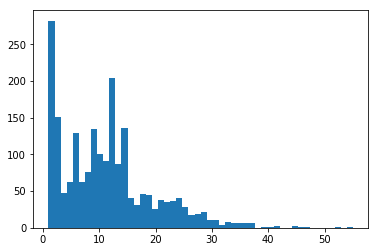

In [3]:
times = np.zeros(0)
for f in a[0][2]:
    x1 = f.rstrip()
    x2 = x1.split(".")
    x3 = x2[0].split("_")
    time = int(x3[2])*3600 + int(x3[3])*60 + int(x3[4])
    times = np.append(times,time)
delta_times = times[1:] - times[:-1]
plt.hist(delta_times, 50)

In [4]:
np.percentile(delta_times,50)
np.max(delta_times)

55.0

### Extracción de fondo

In [18]:
def memoryBGS(file_number = 900, history = 10, static_bg = False, 
              min_px_stab = 10, use_history = True):
    ###Background Subtractor
    ###
    
    #Background removal test
    bgs = cv2.bgsegm.createBackgroundSubtractorCNT()

    #Configure and 'Train' CNT
    bgs.setMinPixelStability(min_px_stab)
    bgs.setUseHistory(use_history)

    for i in range(0,history):
        if not static_bg:
            img = myimread(image_path + file_names[file_number-history+i])
        else:
            img = myimread(image_path + bgm_img_name)
        if type(img) == type(None):
            return (i,image_path + file_names[file_number-history+i])
        bgs.apply(img)
    img = myimread(image_path + file_names[file_number])
    fgm = bgs.apply(img)
    return (img,fgm)

def FGMdenoise(fgmH,fgmS,iters = 10, pre_close_mask = False):
    kernel = np.ones((5,5),np.uint8)
    masked = fgmH
    post_dil_mask = fgmS
    if pre_close_mask:
        post_dil_mask = cv2.morphologyEx(post_dil_mask, cv2.MORPH_OPEN, kernel)

    for i in range(0,iters):
        dilated = cv2.dilate(masked,kernel)
        masked = cv2.bitwise_and(dilated,dilated,mask = post_dil_mask)
    return masked

def getNiceFGM(img_number,denoise_iters = 10,pre_close_mask = False):
    img,fgmH = memoryBGS(img_number,15)
    _,fgmS = memoryBGS(img_number,15,True)
    
    filteredFGM = FGMdenoise(fgmH,fgmS,denoise_iters,pre_close_mask)
    
    plt.subplot(2,3,1)
    plt.imshow(bg_img)
    plt.subplot(2,3,3)
    plt.imshow(img)
    plt.subplot(2,3,4)
    plt.imshow(fgmH)
    plt.subplot(2,3,5)
    plt.imshow(fgmS)
    plt.subplot(2,3,6)
    plt.imshow(filteredFGM)
    plt.subplots_adjust(0,0,2,2,0.1,0)
    
    return (bg_img,img,fgmH,fgmS,filteredFGM)

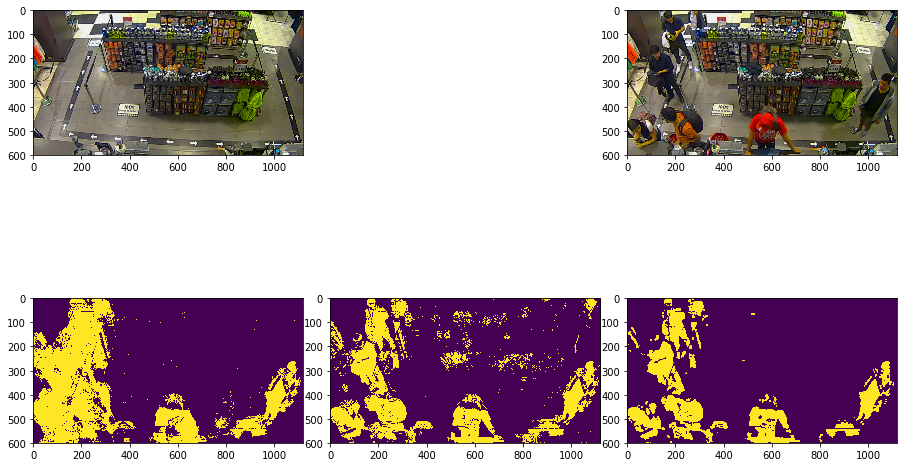

In [19]:
result = getNiceFGM(900,10,True)

In [21]:
cv2.imwrite("C:\\Users\\JH\\Desktop\\fgm_H.png",result[2])
cv2.imwrite("C:\\Users\\JH\\Desktop\\fgm_S.png",result[3])
cv2.imwrite("C:\\Users\\JH\\Desktop\\fgm_final.png",result[4])

True

In [22]:
cv2.imwrite("C:\\Users\\JH\\Desktop\\fondo_crop.png",cv2.cvtColor(result[0],cv2.COLOR_BGR2RGB))
cv2.imwrite("C:\\Users\\JH\\Desktop\\test_crop.png",cv2.cvtColor(result[1],cv2.COLOR_BGR2RGB))

True